# **BERT-based** **Model** **(DistilBERT Model)**


---
DistilBERT is a smaller, faster, and lighter version of BERT (Bidirectional Encoder Representations from Transformers). It retains 97% of BERT's language understanding while being 60% faster and 40% smaller. DistilBERT is trained using a technique called knowledge distillation, where a smaller network (the student) is trained to reproduce the behavior of a larger network (the teacher, in this case, BERT).

In [1]:
# Install transformers library if not already installed
!pip install transformers
# Import required libraries
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/InfosysSB/Preprocessed_Dataset/FakeNewsNet_Preprocessed.csv')


In [4]:
# Display some info about the DataFrame
print("DataFrame info:")
df.info()

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23192 non-null  object
 1   news_url       23196 non-null  object
 2   source_domain  23196 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [5]:
# Check for missing values
df.isnull().sum()

title            4
news_url         0
source_domain    0
tweet_num        0
real             0
dtype: int64

In [6]:
# Handle any missing values in title column (if any)
df['title'].fillna("Unknown Title", inplace=True)

In [7]:
df.isnull().sum()

title            0
news_url         0
source_domain    0
tweet_num        0
real             0
dtype: int64

In [8]:
# Show the first few rows of the dataset
df.head()

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes rape accusation on real...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,people choice award the best red carpet look,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message to on...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma spark rumour of inappr...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl year later upper east siders shock...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


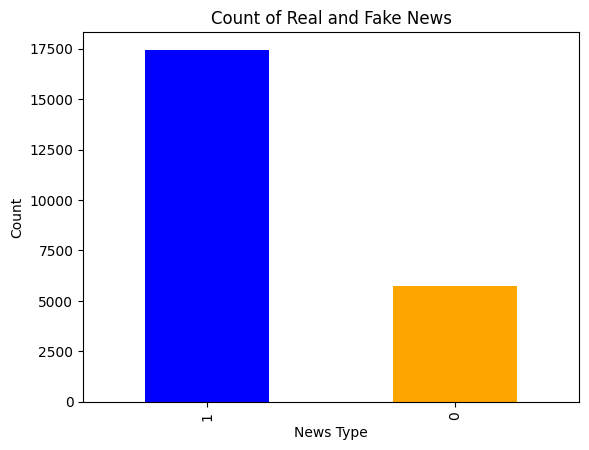

Fake News Count (0): 5755
Real News Count (1): 17441


In [10]:
# Show the count of real and fake news
df['real'].value_counts().plot(kind='bar', color=['blue', 'orange'], title='Count of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

# Print count of real and fake news
# Get the count of 0s and 1s in the 'real' column
count_values = df['real'].value_counts()

# Print the counts with labels
fake_count = count_values[0]  # Count of fake news
real_count = count_values[1]  # Count of real news

print(f"Fake News Count (0): {fake_count}")
print(f"Real News Count (1): {real_count}")

In [11]:
# Combine text features into one column
X = df['title'] + ' ' + df['news_url'] + ' ' + df['source_domain']
y = df['real']

In [13]:
# Split data into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# Further split temp into test (20%) and validation (10%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=101)

In [14]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
# Tokenize text data
def tokenize_text(texts, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Text to encode
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,   # Pad & truncate all sentences
                            pad_to_max_length = True,
                            return_attention_mask = True,  # Construct attn. masks
                            return_tensors = 'pt'      # Return pytorch tensors
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Set maximum sequence length
max_length = 128

In [16]:
# Tokenize and encode training, validation, and test data
X_train_input_ids, X_train_attention_masks = tokenize_text(X_train, max_length)
X_val_input_ids, X_val_attention_masks = tokenize_text(X_val, max_length)
X_test_input_ids, X_test_attention_masks = tokenize_text(X_test, max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
# Load pre-trained DistilBERT model
model_bert = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',  # Use pre-trained model
    num_labels = 2,             # Binary classification (fake vs real news)
    output_attentions = False,  # Do not return attentions weights
    output_hidden_states = False  # Do not return all hidden-states
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(X_train_input_ids) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,  # Default value
    num_training_steps = total_steps
)

# Prepare DataLoader for training
batch_size = 32

train_data = TensorDataset(X_train_input_ids, X_train_attention_masks, torch.tensor(y_train.values))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    model_bert.train()

    total_loss = 0

    for batch in train_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model_bert.zero_grad()

        outputs = model_bert(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks,
            labels=batch_labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average Training Loss: {avg_train_loss}')


Epoch 1/3
----------
Average Training Loss: 0.07970717559132255
Epoch 2/3
----------
Average Training Loss: 0.02403583274670697
Epoch 3/3
----------
Average Training Loss: 0.010643682490328902


In [20]:
# Evaluation on validation set
model_bert.eval()

val_data = TensorDataset(X_val_input_ids, X_val_attention_masks, torch.tensor(y_val.values))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

predictions, true_labels = [], []

for batch in val_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_masks = batch[1].to(device)
    batch_labels = batch[2]

    with torch.no_grad():
        outputs = model_bert(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks
        )

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()

    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(batch_labels.numpy())

In [21]:
# Calculate accuracy and other metrics
val_accuracy_bert = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy (BERT Model): {val_accuracy_bert}")
print(classification_report(true_labels, predictions))

Validation Accuracy (BERT Model): 0.9961173425366695
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       590
           1       1.00      1.00      1.00      1728

    accuracy                           1.00      2318
   macro avg       1.00      0.99      0.99      2318
weighted avg       1.00      1.00      1.00      2318



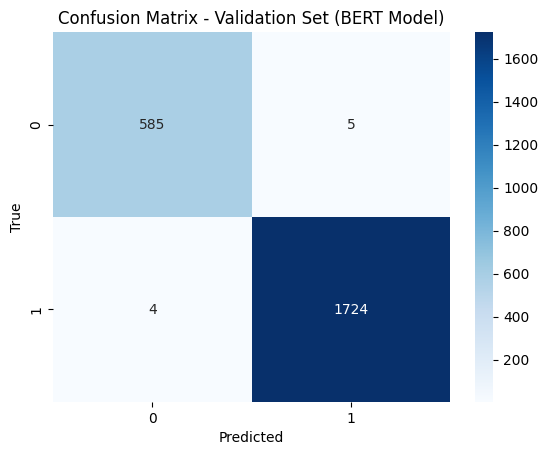

In [22]:
# Confusion matrix for validation set (BERT Model)
val_cm_bert = confusion_matrix(true_labels, predictions)
sns.heatmap(val_cm_bert, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set (BERT Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# Evaluation on test set
test_data = TensorDataset(X_test_input_ids, X_test_attention_masks, torch.tensor(y_test.values))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

predictions_test, true_labels_test = [], []

for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_masks = batch[1].to(device)
    batch_labels = batch[2]

    with torch.no_grad():
        outputs = model_bert(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks
        )

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()

    predictions_test.extend(np.argmax(logits, axis=1))
    true_labels_test.extend(batch_labels.numpy())

In [24]:
# Calculate accuracy and other metrics
test_accuracy_bert = accuracy_score(true_labels_test, predictions_test)
print(f"Test Accuracy (BERT Model): {test_accuracy_bert}")
print(classification_report(true_labels_test, predictions_test))

Test Accuracy (BERT Model): 0.9950441715147598
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1126
           1       1.00      1.00      1.00      3515

    accuracy                           1.00      4641
   macro avg       0.99      0.99      0.99      4641
weighted avg       1.00      1.00      1.00      4641



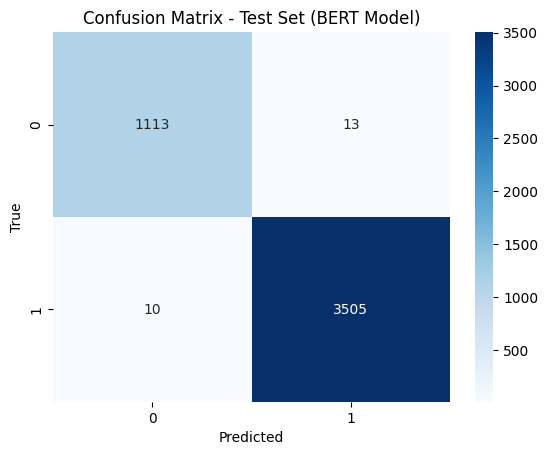

In [25]:
# Confusion matrix for test set (BERT Model)
test_cm_bert = confusion_matrix(true_labels_test, predictions_test)
sns.heatmap(test_cm_bert, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set (BERT Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
# Prediction on custome input
import torch

def predict_custom_input(text):
    """
    Predicts sentiment for a given custom text input.

    Args:
        text: The custom text input string.

    Returns:
        A string indicating predicted sentiment ("Real" or "Fake").
    """
    # Tokenize the custom input
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',  # Use padding argument instead of deprecated pad_to_max_length
        return_attention_mask=True,
        return_tensors='pt'
    )
    custom_input_ids = encoded_dict['input_ids'].to(device)  # Move to device
    custom_attention_mask = encoded_dict['attention_mask'].to(device)

    # Predict with DistilBERT model
    with torch.no_grad():
        outputs = model_bert(custom_input_ids, custom_attention_mask)
    logits = outputs.logits

    # Get the most likely class (Real or Fake)
    prediction = torch.argmax(logits, dim=1).item()  # Get the index of max value
    predicted_class = "Real" if prediction == 1 else "Fake"  # Assuming label 1 is "Real"

    return predicted_class

# Example usage
custom_input = "gwen stefani got dumped by blake shelton jealousy and drama exclusive"
prediction = predict_custom_input(custom_input)
print("Classification for custom input:", prediction)


Classification for custom input: Fake
